In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium.wrappers import TransformReward

In [3]:
# https://gymnasium.farama.org/environments/toy_text/frozen_lake/

In [4]:
# Define an agent that uses the UCBmixLCB algorithm to solve the Mars Rover problem.
class UCBmixLCB:
    def __init__(self, n_states, n_actions, horizon, c=2):
        self.n_states = n_states
        self.n_actions = n_actions
        self.H = horizon
        self.c = c
        self.nsa = np.zeros((horizon, n_states, n_actions))
        self.nsas = np.zeros((horizon, n_states, n_actions, n_states))
        self.R = np.zeros((horizon, n_states, n_actions))
        self.Q = np.ones((horizon, n_states, n_actions)) * 10
        self.N = np.zeros((horizon, n_states, n_actions))
        self.t = 0

    def ucb_select_action(self, h, state):
        # self.t += 1
        ucb_values = self.Q[h, state] + self.c * np.sqrt(1 / (self.N[h, state] + 1e-5))
        return np.argmax(ucb_values)
    
    def lcb_select_action(self, h, state):
        # self.t += 1
        lcb_values = self.Q[h, state] - self.c * np.sqrt(1 / (self.N[h, state] + 1e-5))
        # if there are still actions with 0 counts, select them
        if np.any(self.N[h, state] == 0):
            return np.argmin(self.N[h, state])
        return np.argmax(lcb_values)
    
    def greedy_select_action(self, h, state):
        return np.argmax(self.Q[h, state])
    
    def update(self, h, state, action, reward, next_state):
        self.nsa[h, state, action] += 1
        self.nsas[h, state, action, next_state] += 1
        self.N[h, state, action] += 1
        self.R[h, state, action] += (reward - self.R[h, state, action]) / self.nsa[h, state, action]

    def Q_value_iteration(self):
        # update Q values by value iteration
        for h in range(self.H - 1, -1, -1):
            for state in range(self.n_states):
                for action in range(self.n_actions):
                    if h == self.H - 1:
                        self.Q[h, state, action] = self.R[h, state, action]
                    else:
                        if self.nsa[h, state, action] == 0:
                            continue
                        self.Q[h, state, action] = self.R[h, state, action] + np.sum(self.nsas[h, state, action] / self.nsa[h, state, action] * np.max(self.Q[h + 1], axis=1))

In [5]:
"""Wrapper for transforming the reward."""

# Create the environment for FrozenLake-v0
desc=["SFFF", "FHFH", "FFFH", "HFFG"]
holes = [5, 7, 11, 12]

env = gym.make("FrozenLake-v1", desc=desc, map_name="4x4", is_slippery=True)
env = TransformReward(env, lambda r: r*30 + 0.5)

env1 = gym.make("FrozenLake-v1", desc=desc, map_name="4x4", is_slippery=True)
env1 = TransformReward(env1, lambda r: r*30 + 0.5)

env2 = gym.make("FrozenLake-v1", desc=desc, map_name="4x4", is_slippery=True)
env2 = TransformReward(env2, lambda r: r*30 + 0.5)

panelty = 2

# Define the agent
n_states = env.observation_space.n
n_actions = env.action_space.n
H = 20 # horizon
C = 20 # exploration parameter # C=10 OK
n_experiments = 10
n_episodes = 1000
opt_weight = 0.5
mix_joint_rewards = np.zeros((n_experiments, n_episodes))
ucb_joint_rewards = np.zeros((n_experiments, n_episodes))
greedy_joint_rewards = np.zeros((n_experiments, n_episodes))

In [18]:
mix_agent = UCBmixLCB(env.observation_space.n, env.action_space.n, H, C)
mix_agent.Q = np.load("mix_agent.npy")

ucb_agent = UCBmixLCB(env.observation_space.n, env.action_space.n, H, C)
ucb_agent.Q = np.load("ucb_agent.npy")

greedy_agent = UCBmixLCB(env.observation_space.n, env.action_space.n, H, C)
greedy_agent.Q = np.load("greedy_agent.npy")

In [29]:
mix_epi_length = []
ucb_epi_length = []
greedy_epi_length = []

mix_gift_times = 0
ucb_gift_times = 0
greedy_gift_times = 0

In [36]:
# evaluate the agent
for experiment in range(n_experiments):
    for episode in range(n_episodes):
        state = env.reset()[0]
        state1 = env1.reset()[0]
        state2 = env2.reset()[0]
        p = np.random.uniform(0, 1)
        # trajectory = [state]
        # total_reward = 0
        done = False
        done1 = False
        done2 = False

        for h in range(H):
            action = ucb_agent.ucb_select_action(h, state)
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            if reward > 30:
                ucb_gift_times += 1
            if done or h == H - 1:
                ucb_epi_length.append(h)
                break


        for h in range(H):
            if p < opt_weight:
                action1 = mix_agent.ucb_select_action(h, state1)
            else:
                action1 = mix_agent.lcb_select_action(h, state1)
            next_state1, reward1, done1, _, _ = env1.step(action1)
            state1 = next_state1
            if reward1 > 30:
                mix_gift_times += 1
            if done1 or h == H - 1:
                mix_epi_length.append(h)
                break

        for h in range(H):
            action2 = greedy_agent.greedy_select_action(h, state2)
            next_state2, reward2, done2, _, _ = env2.step(action2)
            state2 = next_state2
            if reward2 > 30:
                greedy_gift_times += 1
            if done2 or h == H - 1:
                greedy_epi_length.append(h)
                break

In [37]:
len(mix_epi_length), len(ucb_epi_length), len(greedy_epi_length)

(30000, 30000, 30000)

In [38]:
print("mix_agent average episode length: ", np.mean(mix_epi_length))
print("ucb_agent average episode length: ", np.mean(ucb_epi_length))
print("greedy_agent average episode length: ", np.mean(greedy_epi_length))
print("mix_agent gift times: ", mix_gift_times)
print("ucb_agent gift times: ", ucb_gift_times)
print("greedy_agent gift times: ", greedy_gift_times)

mix_agent average episode length:  12.966466666666667
ucb_agent average episode length:  14.821166666666667
greedy_agent average episode length:  11.8934
mix_agent gift times:  1625
ucb_agent gift times:  4659
greedy_agent gift times:  563


In [13]:
# Train the agent
for experiment in range(n_experiments):
    ucb_agent = UCBmixLCB(n_states, n_actions, H, C)
    mix_agent = UCBmixLCB(n_states, n_actions, H, C)
    greedy_agent = UCBmixLCB(n_states, n_actions, H, C)

    for episode in range(n_episodes):
        state = env.reset()[0]
        state1 = env1.reset()[0]
        state2 = env2.reset()[0]
        p = np.random.uniform(0, 1)
        # trajectory = [state]
        # total_reward = 0
        done = False
        done1 = False
        done2 = False

        for h in range(H):
            action = ucb_agent.ucb_select_action(h, state)
            next_state, reward, done, _, _ = env.step(action)
            if next_state in holes:
                reward = -panelty

            ucb_agent.update(h, state, action, reward, next_state)
            
            state = next_state
            ucb_joint_rewards[experiment, episode] += reward
            
            if done:
                break


        for h in range(H):
            if p < opt_weight:
                action1 = mix_agent.ucb_select_action(h, state1)
            else:
                action1 = mix_agent.lcb_select_action(h, state1)
            next_state1, reward1, done1, _, _ = env1.step(action1)
            if next_state1 in holes:
                reward1 = -panelty

            mix_agent.update(h, state1, action1, reward1, next_state1)
            
            state1 = next_state1
            mix_joint_rewards[experiment, episode] += reward1
            if done1:
                break

        for h in range(H):
            action2 = greedy_agent.greedy_select_action(h, state2)
            next_state2, reward2, done2, _, _ = env2.step(action2)
            if next_state2 in holes:
                reward2 = -panelty

            greedy_agent.update(h, state2, action2, reward2, next_state2)
            
            state2 = next_state2
            greedy_joint_rewards[experiment, episode] += reward2
            
            if done2:
                break

        # print(trajectory, total_reward)
        ucb_agent.Q_value_iteration()
        mix_agent.Q_value_iteration()
        greedy_agent.Q_value_iteration()

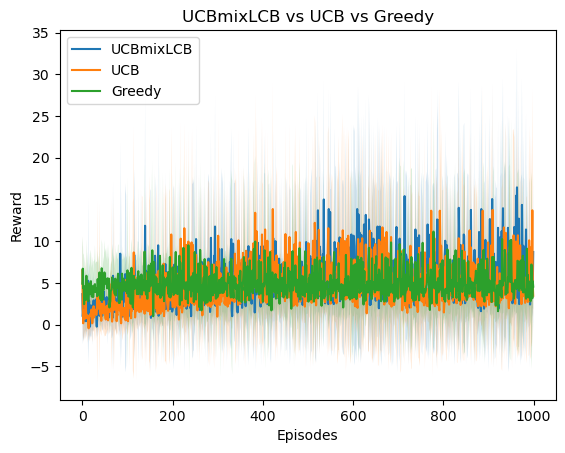

In [14]:
# plot the results of joint_rewards with mean and standard deviation
mix_mean_rewards = np.mean(mix_joint_rewards, axis=0)
mix_std_rewards = np.std(mix_joint_rewards, axis=0)
ucb_mean_rewards = np.mean(ucb_joint_rewards, axis=0)
ucb_std_rewards = np.std(ucb_joint_rewards, axis=0)
greedy_mean_rewards = np.mean(greedy_joint_rewards, axis=0)
greedy_std_rewards = np.std(greedy_joint_rewards, axis=0)
plt.figure()
plt.plot(mix_mean_rewards, label='UCBmixLCB')
plt.fill_between(range(n_episodes), mix_mean_rewards - mix_std_rewards, mix_mean_rewards + mix_std_rewards, alpha=0.2)
plt.plot(ucb_mean_rewards, label='UCB')
plt.fill_between(range(n_episodes), ucb_mean_rewards - ucb_std_rewards, ucb_mean_rewards + ucb_std_rewards, alpha=0.2)
plt.plot(greedy_mean_rewards, label='Greedy')
plt.fill_between(range(n_episodes), greedy_mean_rewards - greedy_std_rewards, greedy_mean_rewards + greedy_std_rewards, alpha=0.2)
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('UCBmixLCB vs UCB vs Greedy')
plt.show()

In [15]:
# plot the cumulative rewards and variance of the three algorithms
mix_cumulative_rewards = np.cumsum(mix_joint_rewards, axis=1)
ucb_cumulative_rewards = np.cumsum(ucb_joint_rewards, axis=1)
greedy_cumulative_rewards = np.cumsum(greedy_joint_rewards, axis=1)

mix_cumulative_rewards_mean = np.mean(mix_cumulative_rewards, axis=0)
mix_cumulative_rewards_std = np.std(mix_cumulative_rewards, axis=0)
ucb_cumulative_rewards_mean = np.mean(ucb_cumulative_rewards, axis=0)
ucb_cumulative_rewards_std = np.std(ucb_cumulative_rewards, axis=0)
greedy_cumulative_rewards_mean = np.mean(greedy_cumulative_rewards, axis=0)
greedy_cumulative_rewards_std = np.std(greedy_cumulative_rewards, axis=0)

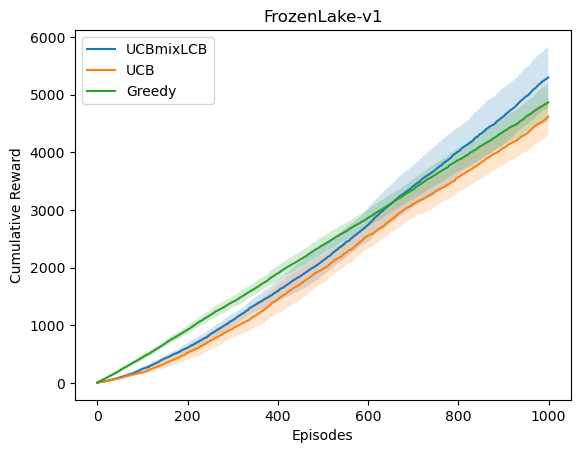

In [16]:
plot_length = 1000
plt.figure()
plt.plot(mix_cumulative_rewards_mean[:plot_length], label='UCBmixLCB')
plt.fill_between(range(plot_length), mix_cumulative_rewards_mean[:plot_length] - mix_cumulative_rewards_std[:plot_length], mix_cumulative_rewards_mean[:plot_length] + mix_cumulative_rewards_std[:plot_length], alpha=0.2)
plt.plot(ucb_cumulative_rewards_mean[:plot_length], label='UCB')
plt.fill_between(range(plot_length), ucb_cumulative_rewards_mean[:plot_length] - ucb_cumulative_rewards_std[:plot_length], ucb_cumulative_rewards_mean[:plot_length] + ucb_cumulative_rewards_std[:plot_length], alpha=0.2)
plt.plot(greedy_cumulative_rewards_mean[:plot_length], label='Greedy')
plt.fill_between(range(plot_length), greedy_cumulative_rewards_mean[:plot_length] - greedy_cumulative_rewards_std[:plot_length], greedy_cumulative_rewards_mean[:plot_length] + greedy_cumulative_rewards_std[:plot_length], alpha=0.2)
# plt.axvline(x=mix_better, color='r', linestyle='--', label='UCBmixLCB outperforms Greedy')
# plt.axvline(x=ucb_better, color='r', linestyle='-.', label='UCB outperforms UCBmixLCB')

# make different color of shaded area for different regions
# plt.fill_between(range(mix_better), 0, 175000, alpha=0.2, color='blue')
# plt.fill_between(range(mix_better, ucb_better), 0, 175000, alpha=0.2, color='green')
# plt.fill_between(range(ucb_better, plot_length), 0, 175000, alpha=0.2, color='red')

plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('FrozenLake-v1')
plt.show()

In [293]:
# save three agents
np.save('ucb_agent', ucb_agent.Q)
np.save('mix_agent', mix_agent.Q)
np.save('greedy_agent', greedy_agent.Q)